In [124]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import yaml
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [227]:
with open ('config.yaml', 'r') as f:
    cfg = yaml.safe_load(f)
    

In [228]:
train = pd.read_csv(cfg['selary']['train_refactor'])
test = pd.read_csv(cfg['selary']['test_refactor'])

In [229]:

y_train = train['Credit_Score']
x_train = train.drop('Credit_Score', axis = 1)

X_train, X_val,  Y_train, Y_val = train_test_split(x_train, y_train, test_size =0.1, random_state =42)

Y_test = test['Credit_Score']
X_test = test.drop('Credit_Score', axis = 1)

X_train.shape, X_val.shape, X_test.shape

((35073, 24), (3897, 24), (7737, 24))

In [230]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)


In [231]:
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train.values, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
Y_train = torch.tensor(Y_train.values, dtype=torch.long)
Y_test = torch.tensor(Y_test, dtype=torch.long)
Y_val = torch.tensor(Y_val.values, dtype=torch.long)

In [232]:
train_t = TensorDataset(X_train, Y_train)
test_t = TensorDataset(X_test, Y_test)
train_val = TensorDataset(X_val, Y_val)

In [233]:
train_loader = DataLoader(train_t, batch_size=64, shuffle=True)
test_loader = DataLoader(test_t, batch_size=64, shuffle=True)
val_loader = DataLoader(train_val, batch_size=64, shuffle=True)

24
46.49224706946826
45.54342643257047
44.9729657876687
44.4291472337285
44.09851676714225
43.61521797883706
43.41993291163054
43.015555955347466
42.882107132770976
42.54251405352452
42.46359842331683
42.22304331767754
42.13888901765229
41.965308705314264
41.90572899677714
41.835896490050146
41.82982101792195
41.742105365776624
41.78198092785038
41.586453896076954
41.77208055531392
41.56938731474955
41.54536443264758
41.554091010914476
41.60786299529623
41.50833948029847
41.63388725968658
41.414148826091015
41.497675682677595
41.40233707623403
41.41685505284638
41.46668111593997
41.339058758782556
41.32898183337978
41.35983562176345
41.31954808704189
41.419604886750705
41.25452750823537
41.33311755930791
41.358722210907544
41.46540619506211
41.282182155085394
41.42620307011683
41.52304944054025
Overfitting early


<function matplotlib.pyplot.show(close=None, block=None)>

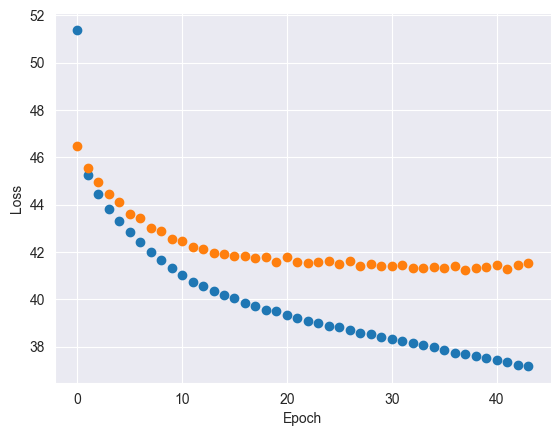

In [246]:
import torch.optim as optim
class CreditScore(nn.Module):
    def __init__(self, input_size):
        super(CreditScore, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 3)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = (self.fc4(x))
        return F.log_softmax(x, dim=1)
        #return x

size = X_train.shape[1]
model = CreditScore(size)

print(size)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

num_epochs = 200
best_val_loss = float('inf')
early_stop_counter = 0
early_stop_patience =5
var_loss_x=[]
var_loss_y=[]
epoch_c=[]
for epch in range(num_epochs):
    epoch_c.append(epch)
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        #print( labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()  * inputs.size(0)
        
        
    ephoch_loss = running_loss / len(train_loader)
    var_loss_x.append(ephoch_loss)
    #print(ephoch_loss)
    
    model.eval()
    var_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            #inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            var_loss +=loss.item()*inputs.size(0)
            
        ephoch_loss_2 = var_loss / len(val_loader)
        print(ephoch_loss_2)
        var_loss_y.append(ephoch_loss_2)
    if var_loss < best_val_loss:
        best_val_loss = var_loss
        early_stop_counter = 0
    else: 
        early_stop_counter +=1
        #if var_loss_y[-1] - min(var_loss_y) > 10.0:
        if early_stop_counter  > early_stop_patience:
            print('Overfitting early')
            break
        #elif ephoch_loss_2 > ephoch_loss:
         #   print('Early stopping')
          #  break
    #print(epoch_c, var_loss_x, var_loss_y)
plt.scatter(epoch_c,var_loss_x)   
plt.scatter(epoch_c, var_loss_y)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show


In [247]:
model.eval()
predicted = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predict = torch.max(outputs, 1)
        predicted.extend(predict.numpy())
        true_labels.extend(labels.numpy())
accuracy = accuracy_score(true_labels, predicted) 
print(accuracy)

0.7246994959286546


In [20]:
if torch.cuda.is_available():
    print('GPU available')